<a href="https://colab.research.google.com/github/nachoacev/practice-data-science/blob/main/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

In this course we'll learn about one of the most important steps on the way to building a great machine learning model: feature engineering. We'll learn how to:

- determine which features are the most important with *mutual information*.
- invent new features in several real-world problem domains.
- encode high-cardinality categoricals with a *target encoding*.
- create segmentation features with *k-means clustering*.
- decompose a dataset's variation into features with *principal component analysis*.

The hands-on exercises build up to a complete notebook that applies all of these techniques to make a submission to the House Prices Getting Started competition. After completing this course, you'll have several ideas that you can use to further improve your performance.

## The Goal of Feature Enggineering

The goal of feature engineering is simply *to make your data better suited to the problem at hand.*

Consider "apparent temperature" measures like the heat index and the wind chill. These quantities attempt to measure the perceived temperature to humans based on air temperature, humidity, and wind speed, things which we can measure directly. You could think of an apparent temperature as the result of a kind of feature engineering, an attempt to make the observed data more relevant to what we actually care about: how it actually feels outside!

You might perform feature engineering to:

- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

For a feature to be useful, *it must have a relationship to the target that your model is able to learn*. Linear models, for instance, are only able to learn linear relationships. So, when using a linear model, your goal is to transform the features to make their relationship to the target linear.

The key idea here is that a transformation you apply to a feature becomes in essence a part of the model itself. Say you were trying to predict the Price of square plots of land from the Length of one side. Fitting a linear model directly to Length gives poor results: the relationship is not linear.

# Mutual Information

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

- easy to use and interpret
- computationally efficient
- theoretically well-founded
- resistant to overfitting
- able to detect any kind of relationship

Mutual information *describes relationships in terms of uncertainty*. The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.

**Mathematical description:**

In information theory, **mutual information** quantifies the amount of information that one random variable contains about another. It measures the **reduction in uncertainty** about one variable given knowledge of the other.

---
Let $X$ and $Y$ be two discrete random variables with joint probability mass function $ p(x, y)$, and marginal distributions $ p(x) $ and $ p(y) $. The **mutual information** $ I(X; Y) $ is defined as:

$$
I(X; Y) = \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x, y) \log \left( \frac{p(x, y)}{p(x)p(y)} \right)
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

import kagglehub

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

fe_course_data_path = kagglehub.dataset_download('ryanholbrook/fe-course-data')

# Load data
df = pd.read_csv(f'{fe_course_data_path}/ames.csv')
df.head()

100%|██████████| 25.8M/25.8M [00:00<00:00, 139MB/s]

Extracting files...


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


In [7]:
def make_mi_score(X, y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

  # We use factorize, so all discrete features should have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


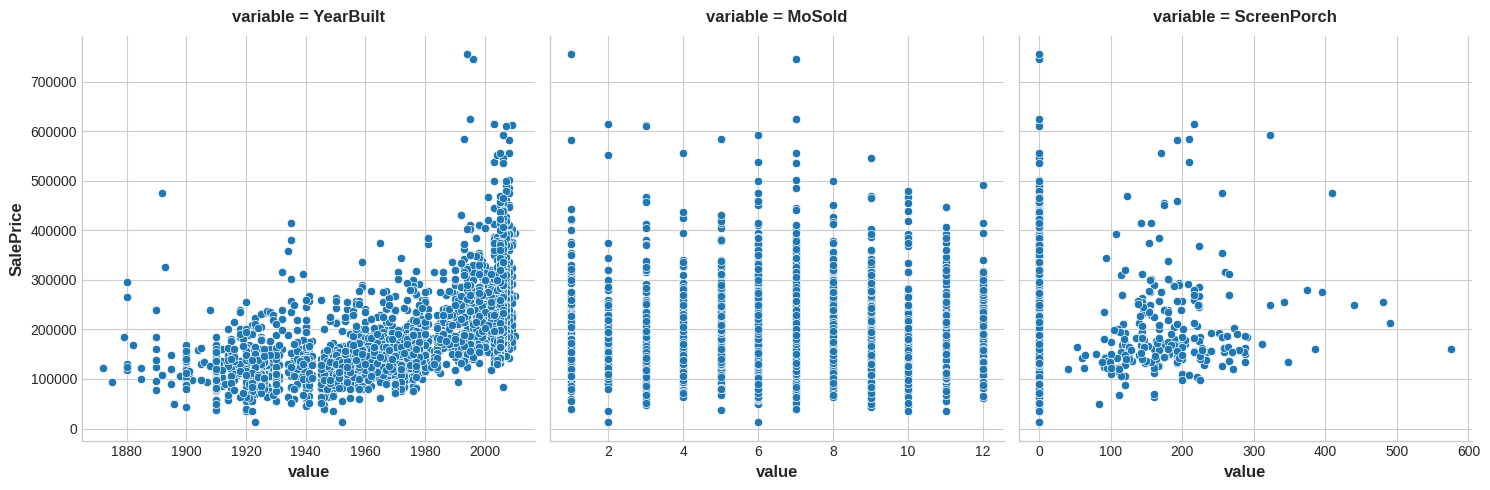

In [11]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

- We observe that ``YearBuilt`` gives more information for the ``SalePrice`` variable, since it tends to constrain the target to a smaller range of possible values.

## Examine MI Scores

In [15]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_score(X, y)

print(mi_scores.head(10))
print(mi_scores.tail(10))

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64
MiscFeature         0.004322
Street              0.003381
Condition2          0.003176
RoofMatl            0.002620
PoolQC              0.001370
Utilities           0.000291
LandSlope           0.000000
BsmtFinSF2          0.000000
Threeseasonporch    0.000000
MoSold              0.000000
Name: MI Scores, dtype: float64


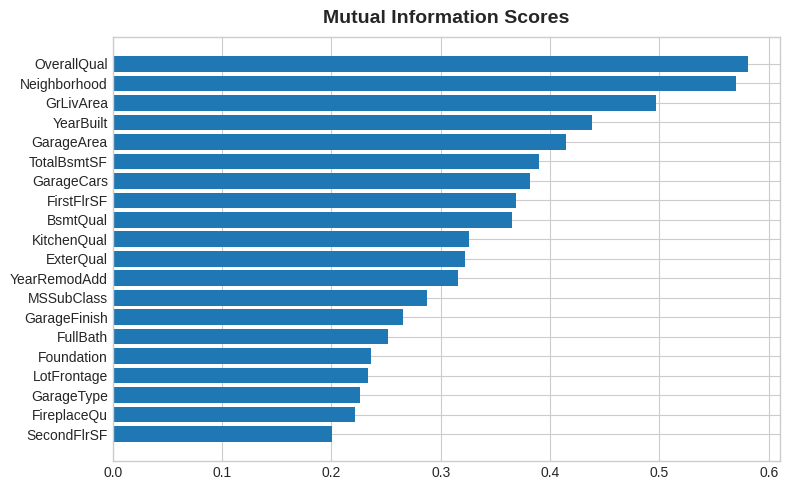

In [20]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

Some common themes among most of these features are:

- Location: ``Neighborhood``.
- Size: all of the ``Area`` and ``SF`` features, and counts like ``FullBath`` and ``GarageCars``.
- Quality: all of the ``Qual`` features.
- Year: ``YearBuilt`` and ``YearRemodAdd``.
- Types: descriptions of features and styles like ``Foundation`` and ``GarageType``.

These are all the kinds of features you'll commonly see in real-estate listings (like on Zillow), It's good then that our mutual information metric scored them highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant to the average home buyer.

In this step you'll investigate possible interaction effects for the BldgType feature. This feature describes the broad structure of the dwelling in five categories:

```
Bldg Type (Nominal): Type of dwelling

  1Fam	 Single-family Detached
  2FmCon 	Two-family Conversion; originally built as one-family dwelling
  Duplx	Duplex
  TwnhsE	Townhouse End Unit
  TwnhsI	Townhouse Inside Unit
```
The ``BldgType`` feature didn't get a very high MI score. A plot confirms that the categories in ``BldgType`` don't do a good job of distinguishing values in SalePrice (the distributions look fairly similar, in other words):

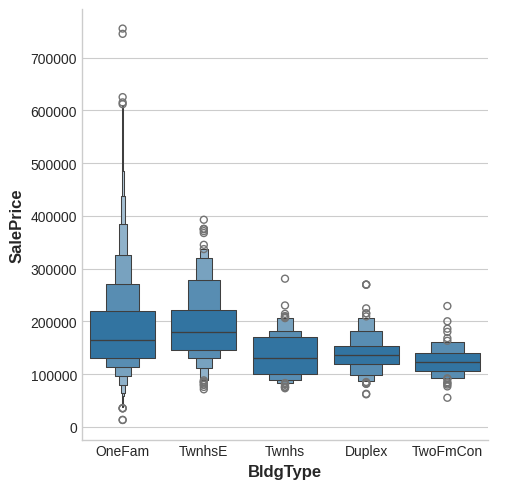

In [22]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. Investigate whether ``BldgType`` produces a significant interaction with the following:
```
GrLivArea  # Above ground living area
```


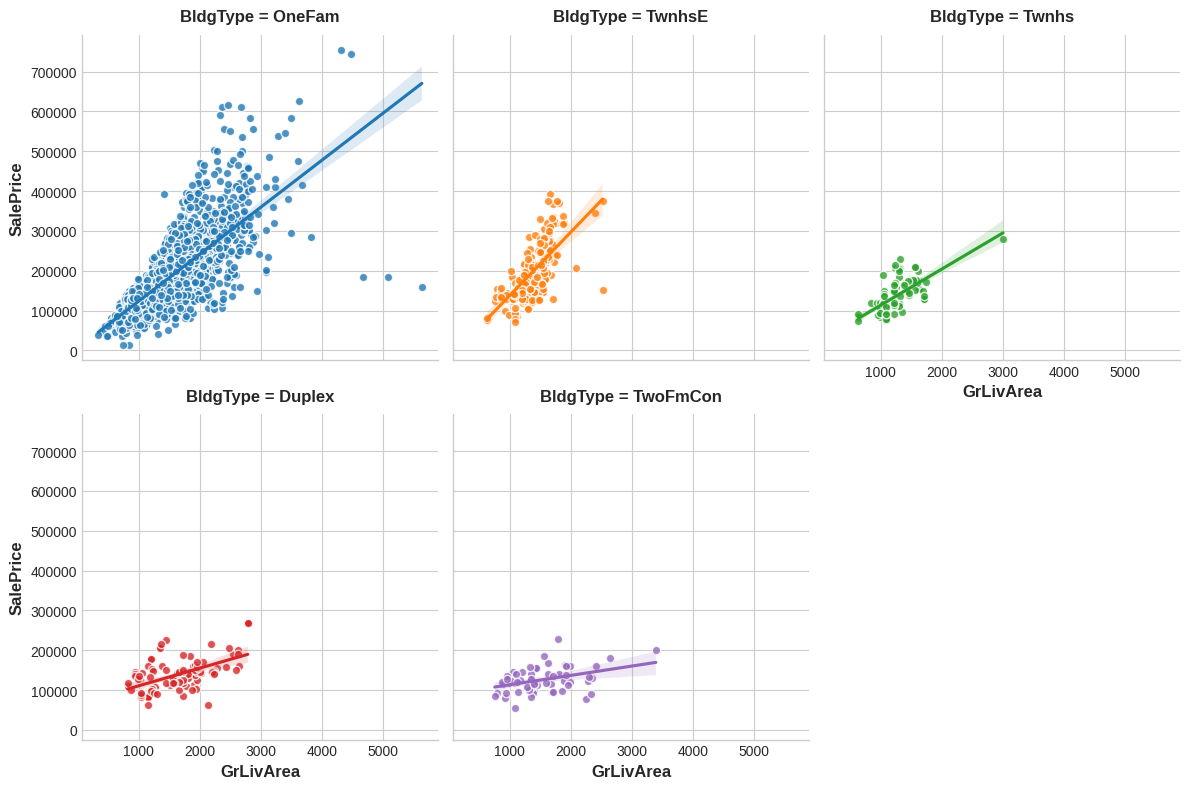

In [23]:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4
)

- The trends lines within each category of ``BldgType`` are clearly very different, indicating an interaction between these features. Since knowing ``BldgType`` tells us more about how ``GrLivArea`` relates to ``SalePrice``, we should consider including ``BldgType`` in our feature set.